In [1]:
"""datosBI = data.copy()
datosBI['Age'] = datosBI['Age'].astype('str').str.replace('.', ',')
datosBI['Fare'] = datosBI['Fare'].astype('str').str.replace('.', ',')
datosBI.to_csv('Titanic_BI.csv')"""

"datosBI = data.copy()\ndatosBI['Age'] = datosBI['Age'].astype('str').str.replace('.', ',')\ndatosBI['Fare'] = datosBI['Fare'].astype('str').str.replace('.', ',')\ndatosBI.to_csv('Titanic_BI.csv')"

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor

plt.style.use("ggplot")


def corr_matrix(data, figsize=None):
    num_cols = data.select_dtypes(["number"])

    if figsize==None:
        figsize=(num_cols.shape[1]* 1.2, num_cols.shape[1]*0.9)

    plt.figure(figsize=figsize)
    sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
    plt.title('Matriz de correlación')
    plt.show()


def num_boxplots(df, ncols=2, figsize=[24,0], hspace=0.7, wspace=0.1):
    # Seleccionar todas las columnas numéricas
    num_cols = df.select_dtypes(include=["number"]).columns

    # Crear la figura y los ejes con 2 columnas
    n_rows = int(np.ceil(len(num_cols) / ncols))  # Número de filas necesarias

    # Cálculo de altura de la gráfica
    if figsize[1]==0:
        figsize[1] = n_rows * 2

    # Definición del DataFrame con las asimetrías
    asimetria = pd.DataFrame(columns=num_cols, index=['Asimetria'])

    # Ajustar espacio entre subgráficos
    fig, ax = plt.subplots(nrows=n_rows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    # Recorrer las columnas numéricas y crear boxplots
    for i, col in enumerate(num_cols):
        fila = i // ncols  # Índice de fila
        columna = i % ncols  # Índice de columna
        
        sns.boxplot(x=df[col], ax=ax[fila, columna])
        ax[fila, columna].set_title(col)
        ax[fila, columna].set_xlabel('')

        asimetria.loc['Asimetria', col] = round(df[col].skew(), 5)

    # Si hay subgráficos vacíos (por número impar de columnas), ocultarlos
    if len(num_cols) % ncols != 0:
        for i in range(ncols - (len(num_cols) % ncols)):
            ax[-1, -i-1].axis("off")

    display(asimetria)
    plt.show()


def asim_boxcox(data, cols, figsize=[22, 0], hspace=0.5, wspace=0.2):
    if type(cols) == str:
        cols = [cols]

    if figsize[1] == 0:
        figsize[1] = len(cols)*3

    fig, ax = plt.subplots(nrows = len(cols), ncols=2, figsize = figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    # Asegurarse de que ax sea siempre 2D
    if len(cols) == 1:
        ax = np.array([ax])  # convierte en 2D: shape (1, 2)

    for i, col in enumerate(cols):
        sns.histplot(data[col].dropna(), kde=True, ax=ax[i, 0])
        ax[i, 0].set_title('Distribución original de ' + col)
        ax[i, 0].set_xlabel('')
        ax[i, 0].set_ylabel('Frecuencia')

        # 2. Transformación Box-Cox
        # Box-Cox requiere valores positivos, por lo que si existen ceros, se puede sumar una constante.
        # Aquí sumamos 1 para garantizarlo. Además, extraemos los datos y eliminamos los nulos.
        building_area_boxcox, fitted_lambda = boxcox(data[col].dropna() + 1)
        # building_area_boxcox devuelve un array con los valores transformados.

        # Guardamos el resultado en una nueva columna (alineamos los índices)
        data.loc[data[col].dropna().index, col + '_boxcox'] = building_area_boxcox

        sns.histplot(building_area_boxcox, kde=True, ax=ax[i, 1])
        ax[i, 1].set_title('Distribución de ' + col + '_boxcox')
        ax[i, 1].set_xlabel(col)
        ax[i, 1].set_ylabel('Frecuencia')

    plt.show()


def cat_boxplot_yContinua(data, cols, y, figsize = None, width_ratios = None, rotation = None, wspace=0.4):
    if width_ratios == None:
        width_ratios = [data.nunique()[col] for col in cols]

    if figsize==None:
        fig, ax = plt.subplots(nrows=1, ncols=len(cols), width_ratios=width_ratios)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(cols), figsize=figsize, width_ratios=width_ratios)
        
    fig.subplots_adjust(wspace=wspace)

    for i, col in enumerate(cols):
        sns.boxplot(x=col, y=y, data=data, ax=ax[i])
        ax[i].set_xlabel(col)
        ax[i].set_ylabel(y)

        if rotation != None:
            if rotation[i] == True:
                ax[i].tick_params(axis='x', rotation=30)
        
    plt.show()


def cat_yCat_test(data, y, cols=None, figsize = None, width_ratios = None, rotation = None, wspace=0.2):
    corr_cat = pd.DataFrame(columns=["Chi2", "p-value"])
    
    if cols == None:
        cols = data.select_dtypes('object').columns

    if figsize == None:
        figsize = [min(22, len(y)*1.5), max(data[cols].nunique())]

    fig, ax = plt.subplots(nrows=1, ncols=len(cols), figsize=figsize)
        
    fig.subplots_adjust(wspace=wspace)

    for i, col in enumerate(cols):
        contingency_table_normalized = pd.crosstab(data[col], data[y], normalize='index')
        contingency_table = pd.crosstab(data[col], data[y])
        
        sns.heatmap(contingency_table_normalized, annot=True, fmt='.2f', cmap='Reds', ax=ax[i])
        ax[i].set_xlabel(y)
        ax[i].set_ylabel(col)

        if rotation != None:
            if rotation[i] == True:
                ax[i].tick_params(axis='x', rotation=30)
                    
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        corr_cat.loc[col] = pd.Series({"Chi2": chi2, "p-value": p})
        
    plt.show()
    return corr_cat


def preprocessor_creator(OrdinalE_cols=None, RScaler_cols=None, OH_cols=None):
    transformers = []

    if OrdinalE_cols != None:
        transformers.append(("Ordinal", OrdinalEncoder(), OrdinalE_cols))
    if RScaler_cols != None:
        transformers.append(("RobustScaler", RobustScaler(), RScaler_cols))
    if OH_cols != None:
        transformers.append(("OneHot", OneHotEncoder(), OH_cols))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough', verbose_feature_names_out=False)
    
    return preprocessor

# Análisis y selección de variables

In [152]:
data = pd.read_csv("Titanic_Dataset.csv")
data_test = pd.read_csv('Titanic_test.csv')

data.index = data.pop('PassengerId')
data_test.index = data_test.pop('PassengerId')
display(data, data_test)

data.info()
display(pd.Series(data.isnull().sum(), name="Nulos"))

print('Filas antes de eliminar duplicados:', data.shape[0])
data.drop_duplicates(inplace=True)
print('Filas después de eliminar duplicados:', data.shape[0])

# Pclass: 1ª clase, 2ª clase o 3ª.
# SibSp: No. of siblings / spouses aboard the Titanic
# Parch: No. of parents / children aboard the Titanic
# Fare: Tarifa de billete
# Embarked -> Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Name: Nulos, dtype: int64

Filas antes de eliminar duplicados: 891
Filas después de eliminar duplicados: 891


In [153]:
data.loc[data['Embarked'].isnull(),'Embarked'] = 'S'
data_test.loc[data_test['Fare'].isnull(),'Fare'] = data['Fare'].mean()
data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
6,0,3,male,NaN,0,0,8.4583,Q
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.0750,S
9,1,3,female,27.0,0,2,11.1333,S


In [182]:
data_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,False
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,False
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,False
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,False
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,False
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,True
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,False
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False


In [ ]:
data['Age_missing'] = data['Age'].isnull()
data.loc[data['Age'].isnull(), 'Age'] = data['Age'].median()

data_test['Age_missing'] = data_test['Age'].isnull()
data_test.loc[data_test['Age'].isnull(), 'Age'] = data['Age'].median()

## Estudio características numéricas

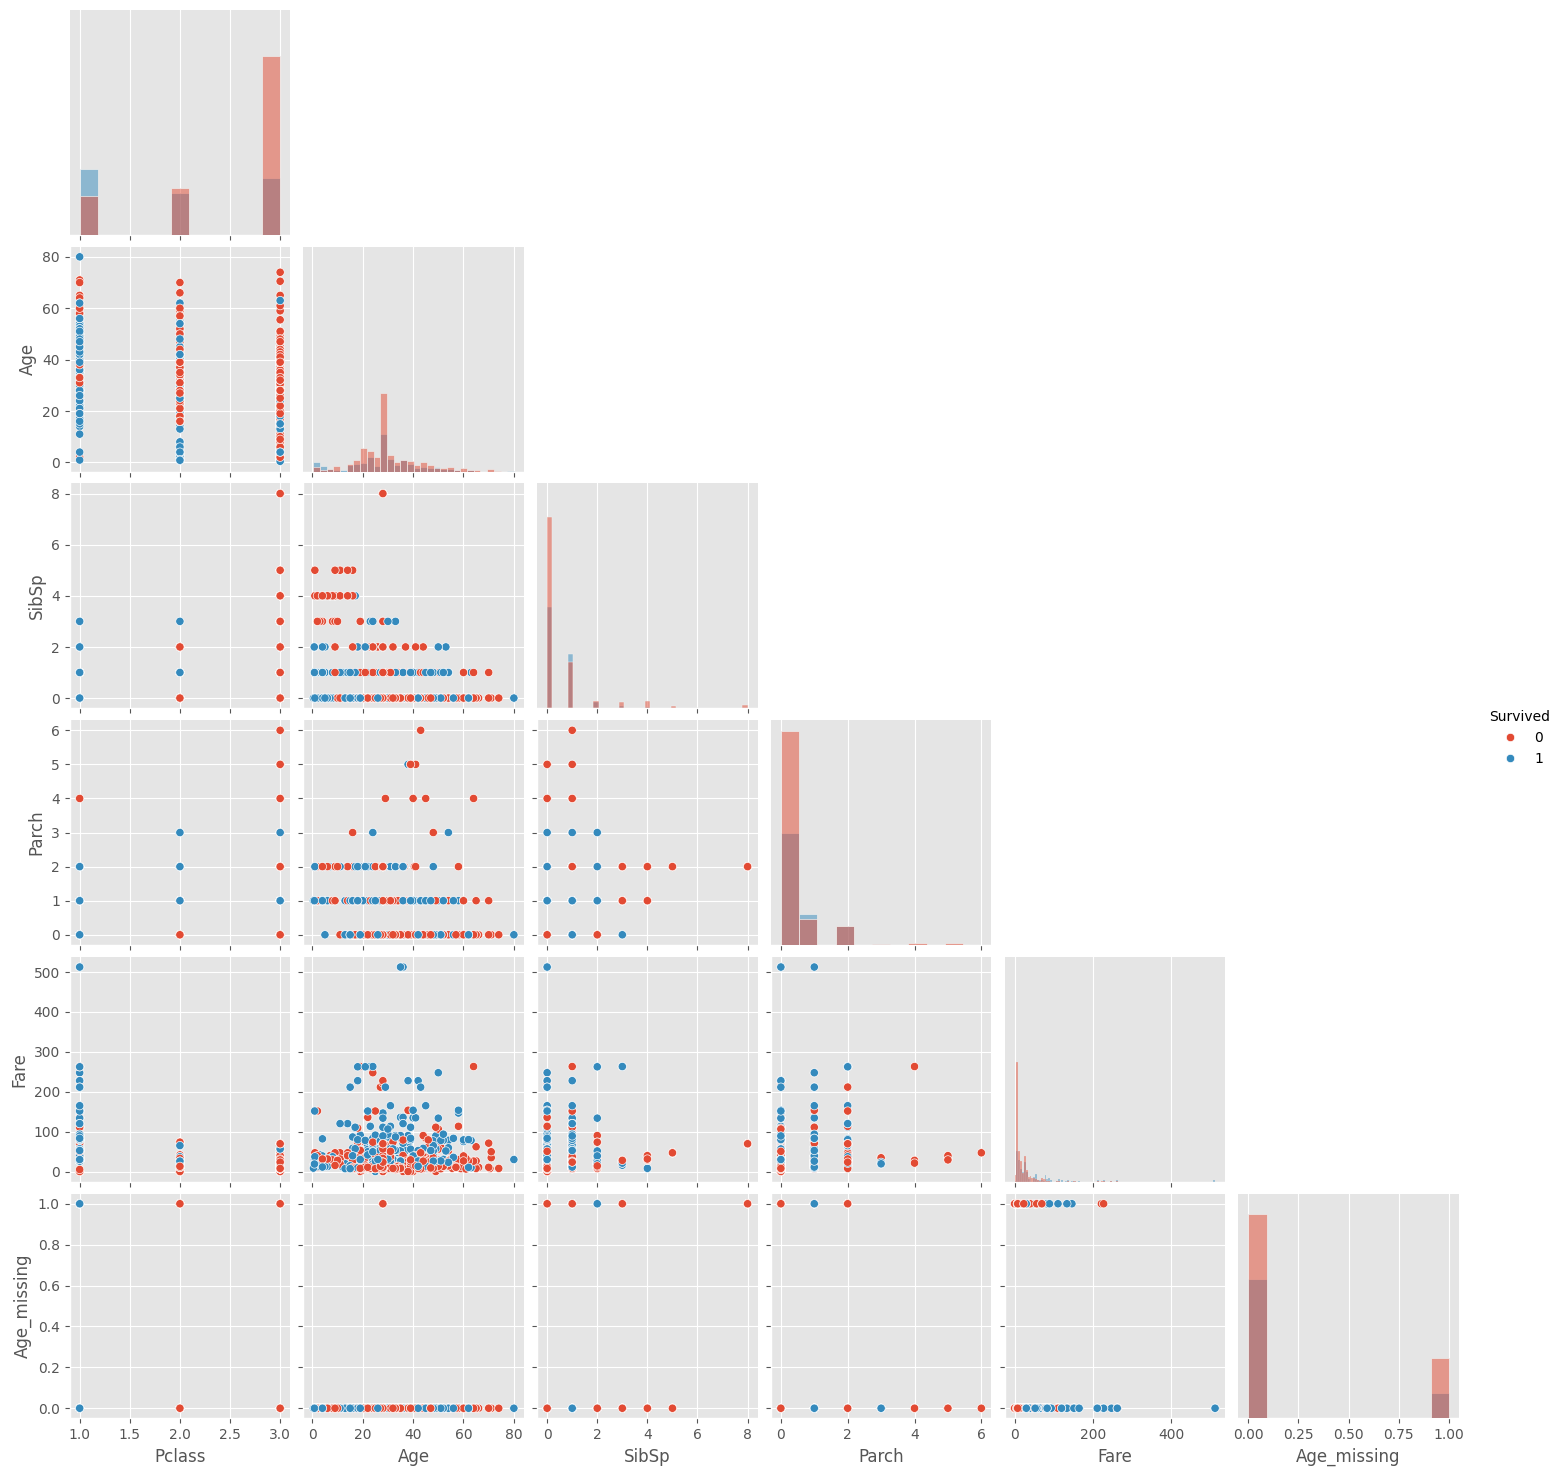

In [155]:
sns.pairplot(data, hue='Survived', diag_kind='hist', corner=True)

plt.show()

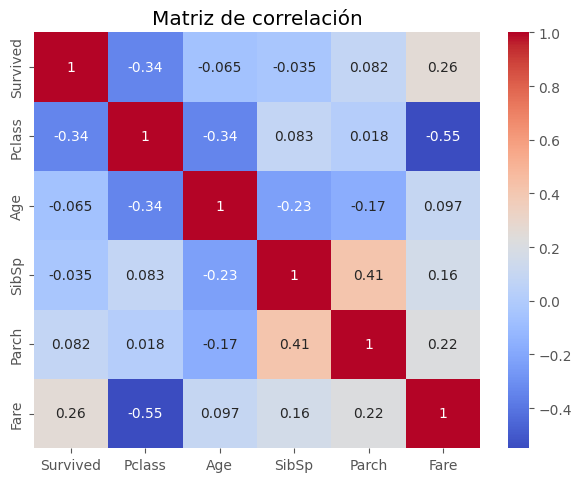

,Survived,Pclass,Age,SibSp,Parch,Fare
Asimetria,0.47852,-0.63055,0.51024,3.69535,2.74912,4.78732


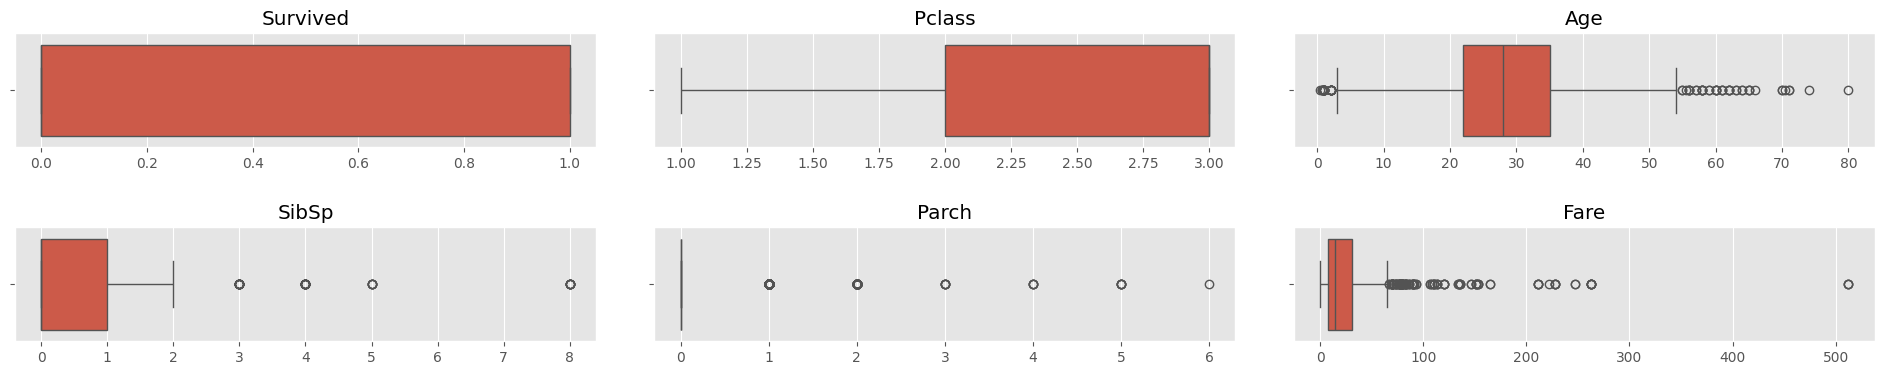

In [156]:
corr_matrix(data)
num_boxplots(data, ncols=3)

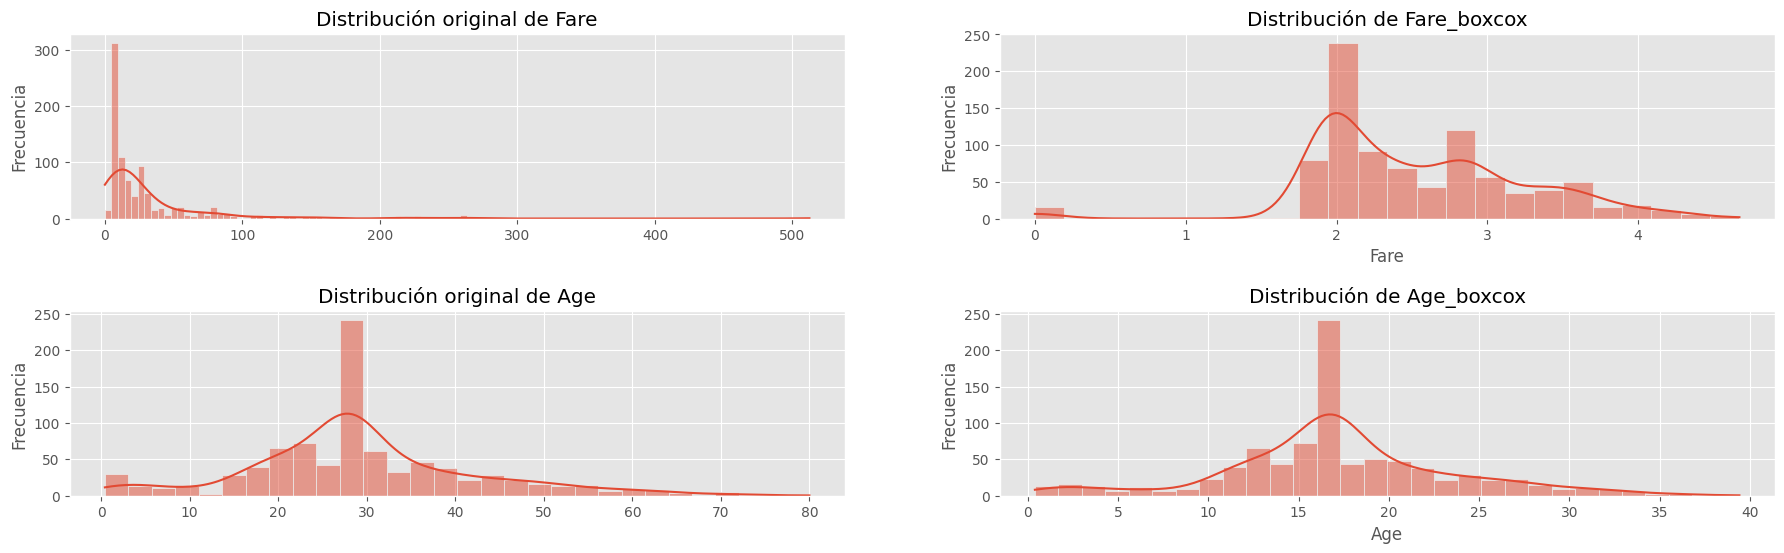

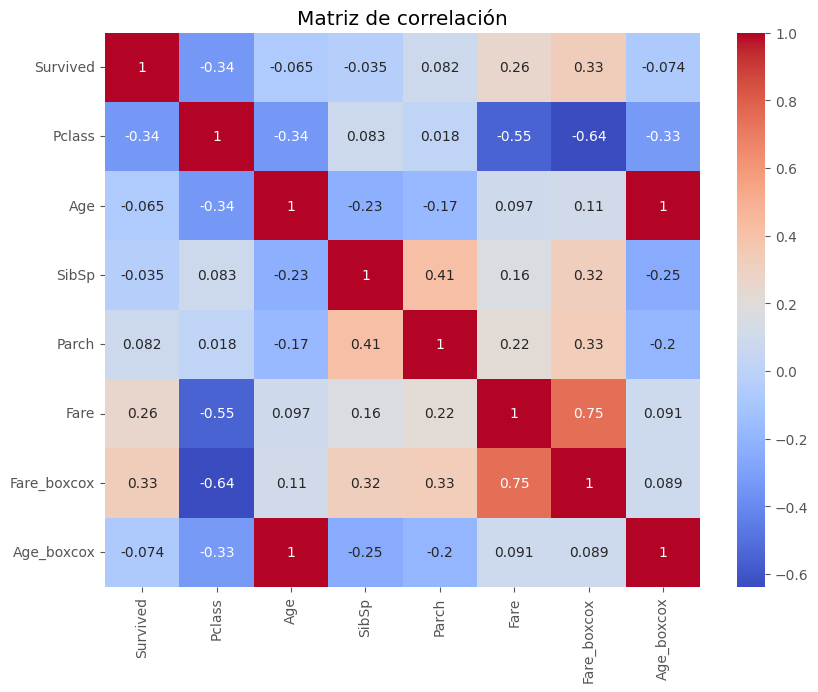

In [157]:
asim_boxcox(data, ['Fare', 'Age'])
corr_matrix(data)

### Observaciones
Como las variables Age, SibSp y Parch tienen una muy baja correlación (incluso después de normalizarlas) son altas candidatas a ser eliminadas. Sin embargo, esperaremos a realizar un RandomForest para ver cuales cobran importancia en la práctica. 
En especial vemos la variable Age que además tiene varios valores nulos, lo que da una mayor tendencia a ser eliminada.
Antes de entrenar el RandomForest, estudiaremos las variables categóricas.

## Variables Categóricas

In [158]:
obj_cols = data.select_dtypes(object)

obj_cols.nunique()

Sex         2
Embarked    3
dtype: int64

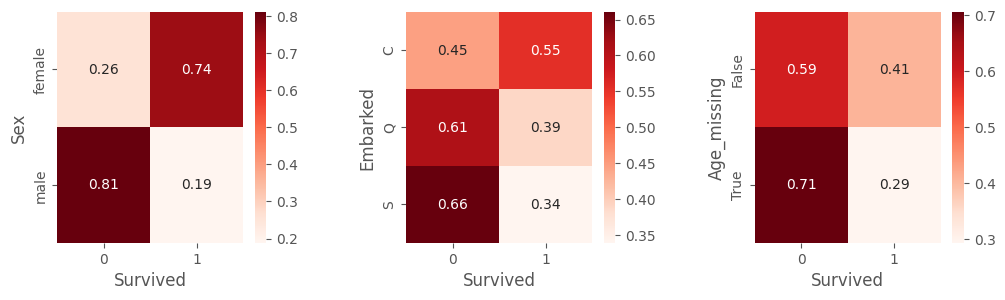

,Chi2,p-value
Sex,260.717020,1.197357e-58
Embarked,25.964453,2.300863e-06
Age_missing,7.105975,7.682742e-03


In [159]:
cat_yCat_test(data, 'Survived', cols=['Sex', 'Embarked', 'Age_missing'], wspace=0.5)

Parece que las variables categóricas Sex, Embarked y Age_missing tienen una alta influencia en si sobreviven o no, por lo que serán variables interesantes de matener.

## RandomForest para selección de características

In [160]:
X = data.copy()
y = X.pop('Survived')

In [161]:
preprocessor = preprocessor_creator(OH_cols=['Embarked'], OrdinalE_cols=['Sex'])

model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

pipeline_forest = Pipeline(steps=[
    ('prep', preprocessor),
    ('RForest', model)
])

for age in ['Age', 'Age_boxcox']:
    for fare in ['Fare', 'Fare_boxcox']:
        scores = cross_val_score(pipeline_forest, 
                                   X.drop([age, fare], axis=1), y,
                                   cv=5,
                                   scoring='f1')
        print(f'Accuracy:\t{scores.mean():.04},\t\tVariables incluidas: "{age}" y "{fare}".')
        

Accuracy:	0.744,		Variables incluidas: "Age" y "Fare".
Accuracy:	0.7457,		Variables incluidas: "Age" y "Fare_boxcox".
Accuracy:	0.7515,		Variables incluidas: "Age_boxcox" y "Fare".
Accuracy:	0.7422,		Variables incluidas: "Age_boxcox" y "Fare_boxcox".


Debido a la mínima diferencia entre las diferentes exclusiones de variables transformadas o crudas, mantendremos la tabla con las variables Age y Fare. En caso de entrenar modelos que se beneficien de la Normalidad de las variables, se recuperarán las variables transformadas.

In [162]:
X.drop(['Age_boxcox', 'Fare_boxcox'], axis=1, inplace=True)

In [163]:
pipeline_forest.fit(X, y)

feature_importances = {name: score for name, score in zip(list(X), model.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
display(feature_importances_sorted)

Pclass         0.262182
Fare           0.241507
Parch          0.086828
Embarked       0.049926
Age_missing    0.038381
SibSp          0.014698
Sex            0.013615
Age            0.007706
dtype: float64

# Entrenamiento

In [166]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)

print(f"Tamaño de X_train: {len(X_train)}")
print(f"Tamaño de X_val: {len(X_val)}")

Tamaño de X_train: 668
Tamaño de X_val: 223


In [167]:
# models será una lista de tuplas de la forma (name, model, preprocessor, param_grid)
def entrenamiento(X_train, y_train, X_val, y_val, models, scoring, ncols_ROC=4):
    # Guardamos un registro de los resultados y de los modelos entrenados
    resultados = pd.DataFrame(columns=['F1', 'Accuracy', 'Precission', 'Recall'])
    entrenados = dict()

    # Las curvas ROC se dispondrán en una gráfica con 4 columnas. Las filas se cacularán entonces según el número de modelos a entrenar.
    nrows_ROC = (len(models)-1)//ncols_ROC + 1
    fig, ax = plt.subplots(nrows=nrows_ROC, ncols=min(len(models), ncols_ROC), figsize=(min(17, len(models) * 4.5), 4* nrows_ROC))

    # Por cada modelo, con sus características escritas en tuplas de la forma (name, model, preprocessor, param_grid).
    for i, model in enumerate(models):
        name = model[0]
        estimator = model[1]
        preprocessor = model[2]
        param_grid = model[3]

        #Entrenamos el modelo con el preprocesador y el estimador solicitado. 
        pipeline = Pipeline(steps=[
            ('pre', preprocessor),
            ('model', estimator)
        ])

        # Si se ha incluido param_grid, entonces hará un GridSearchCV, dejando entonces el modelo asignado en 'guardado'. 
        # Posteriormente se entrena.
        if param_grid != None:
            entrenado = GridSearchCV(pipeline, param_grid, cv=5,
                                    scoring=scoring, return_train_score=True,
                                    verbose=1)
        else:
            entrenado = pipeline

        entrenado.fit(X_train, y_train)

        # Una vez entrenado, se realizan predicciones y se guardan los resultados.
        y_pred = entrenado.predict(X_val)

        resultados.loc[name, :] = [f1_score(y_pred, y_val),
                                   accuracy_score(y_pred, y_val), 
                                   precision_score(y_pred, y_val), 
                                   recall_score(y_pred, y_val)]
        
        print(f'Entrenado {name}. F1-score: {f1_score(y_pred, y_val):0.5}. Confusion Matrix:')
        display(pd.DataFrame(confusion_matrix(y_val, y_pred)))

        # Se muestran los mejores parámetros en caso de GridSearchCV
        if param_grid != None:
            print(f'Mejores parámetros:')
            
            if type(param_grid) == list:
                parametros = list({key for d in param_grid for key in d.keys()})
            else:
                parametros = param_grid.keys()
                
            display(pd.DataFrame(pd.Series(entrenado.best_estimator_.get_params())).loc[parametros].T)
        print('-'*100)

        # Mostramos las curvas ROC. Si solo tiene una columna, entonces solo hay que asignar a cada gráfica el número de columna, 
        # y si solo tiene una fila, entonces no hay que asignar ningún valor para que no devuelva error.
        if nrows_ROC > 1:
            RocCurveDisplay.from_estimator(entrenado, X_val, y_val, ax=ax[i//ncols_ROC, i%ncols_ROC], name=name, pos_label=1)
            ax[i//ncols_ROC, i%ncols_ROC].set_title(name)
            ax[i//ncols_ROC, i%ncols_ROC].set_xlabel('False Positive Rate')
            ax[i//ncols_ROC, i%ncols_ROC].set_ylabel('True Positive Rate')
        elif len(models) > 1:
            RocCurveDisplay.from_estimator(entrenado, X_val, y_val, ax=ax[i%ncols_ROC], name=name, pos_label=1)
            ax[i%ncols_ROC].set_title(name)
            ax[i%ncols_ROC].set_xlabel('False Positive Rate')
            ax[i%ncols_ROC].set_ylabel('True Positive Rate')
        else:
            RocCurveDisplay.from_estimator(entrenado, X_val, y_val, ax=ax, name=name, pos_label=1)
            ax.set_title(name)
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')

        # Guardamos el modelo
        entrenados[name] = entrenado

    # Si sobran casillas de la última fila de las gráficas, se eliminan.
    if len(models) % ncols_ROC != 0:
        for i in range(4 - (len(models) % ncols_ROC)):
            if nrows_ROC > 1:
                ax[-1, -i-1].axis("off")

    display(resultados)
    plt.tight_layout()
    plt.show()

    return entrenados
        

Entrenado Logistic. F1-score: 0.74157. Confusion Matrix:


,0,1
0,111,25
1,21,66


----------------------------------------------------------------------------------------------------
Entrenado SVC. F1-score: 0.78161. Confusion Matrix:


,0,1
0,117,19
1,19,68


----------------------------------------------------------------------------------------------------
Entrenado RandomForest. F1-score: 0.73256. Confusion Matrix:


,0,1
0,114,22
1,24,63


----------------------------------------------------------------------------------------------------
Entrenado XGBoost. F1-score: 0.77273. Confusion Matrix:


,0,1
0,115,21
1,19,68


----------------------------------------------------------------------------------------------------


,F1,Accuracy,Precission,Recall
Logistic,0.741573,0.793722,0.758621,0.725275
SVC,0.781609,0.829596,0.781609,0.781609
RandomForest,0.732558,0.793722,0.724138,0.741176
XGBoost,0.772727,0.820628,0.781609,0.764045


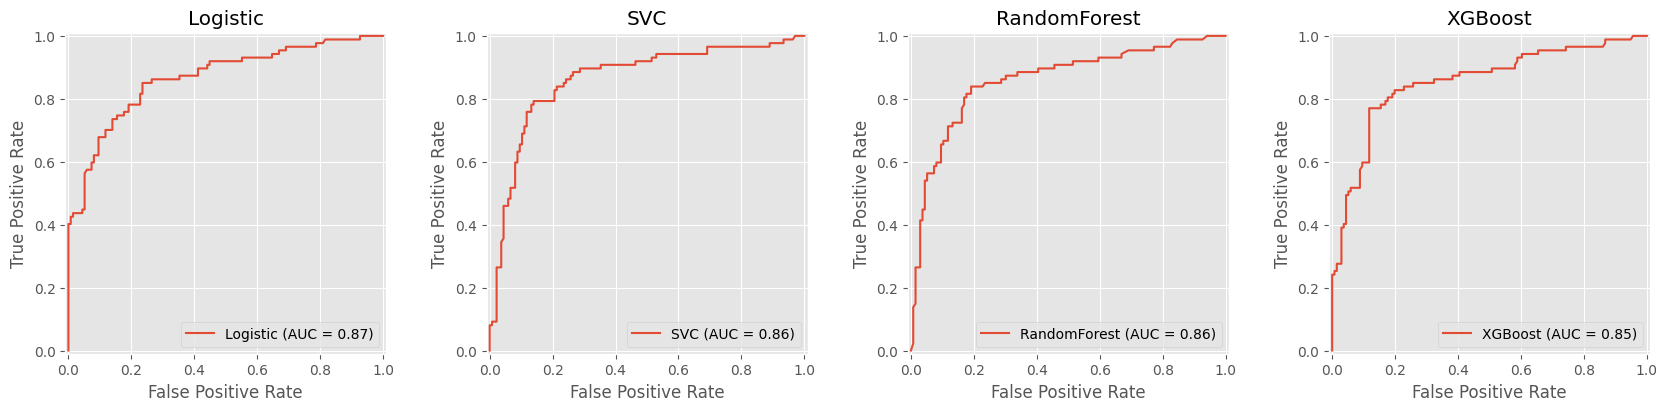

In [ ]:
preprocessor_Scaler = preprocessor_creator(OH_cols=['Embarked'], OrdinalE_cols=['Sex'], RScaler_cols=X_train.select_dtypes('number').columns.tolist())
preprocessor = preprocessor_creator(OH_cols=['Embarked'], OrdinalE_cols=['Sex'])

# Entrenamiento
models = [('Logistic', LogisticRegression(), preprocessor_Scaler, None),
          ('SVC', SVC(), preprocessor_Scaler, None),
          ('RandomForest', RandomForestClassifier(n_jobs=-1, n_estimators=800), preprocessor, None),
          ('XGBoost', XGBClassifier(n_jobs=-1), preprocessor, None)]

resultados = entrenamiento(X_train, y_train, X_val, y_val, models=models, scoring='f1')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Entrenado Logistic. F1-score: 0.76042. Confusion Matrix:


,0,1
0,104,32
1,14,73


Mejores parámetros:


,model__C,model__class_weight
0,10,balanced


----------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Entrenado SVC. F1-score: 0.77193. Confusion Matrix:


,0,1
0,118,18
1,21,66


Mejores parámetros:


,model__degree,model__C,model__kernel
0,2,10,poly


----------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Entrenado RandomForest. F1-score: 0.75309. Confusion Matrix:


,0,1
0,122,14
1,26,61


Mejores parámetros:


,model__max_depth,model__max_leaf_nodes,model__min_samples_split
0,8,None,3


----------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Entrenado XGBoost. F1-score: 0.7362. Confusion Matrix:


,0,1
0,120,16
1,27,60


Mejores parámetros:


,model__n_estimators,model__learning_rate,model__max_depth
0,100,0.02,5


----------------------------------------------------------------------------------------------------


,F1,Accuracy,Precission,Recall
Logistic,0.760417,0.793722,0.83908,0.695238
SVC,0.77193,0.825112,0.758621,0.785714
RandomForest,0.753086,0.820628,0.701149,0.813333
XGBoost,0.736196,0.807175,0.689655,0.789474


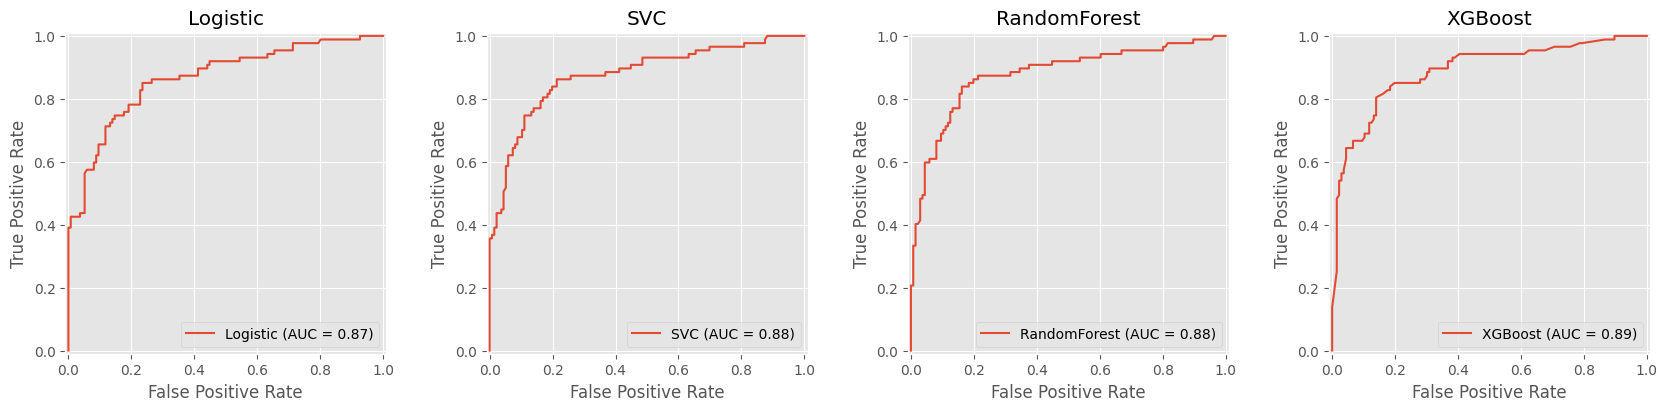

In [ ]:
# Grids para Logistic y SVC. Preprocesador con escalado
param_grid_Logistic = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced']
}

param_gridSVC = [{'model__kernel': ['linear'], 'model__C': [5, 8, 10, 15, 20]},
                 {'model__kernel': ['poly'], 'model__C': [5, 8, 10, 15, 20], 'model__degree': [2, 3, 4]}]

preprocessor_Scaler = preprocessor_creator(OH_cols=['Embarked'], OrdinalE_cols=['Sex'], RScaler_cols=X_train.select_dtypes('number').columns.tolist())


# Grids para RandomForest y XGBoost. Preprocesador sin escalado
param_gridRF = {'model__max_depth': [5, 6, 7, 8], 'model__max_leaf_nodes': [126, 256, None], 'model__min_samples_split': [2, 3, 4, 5, 7, 10]}

param_gridXGB = {
    'model__n_estimators': [60, 80, 100, 200],
    'model__learning_rate': [0.1, 0.05, 0.02],
    'model__max_depth': [5, 6, 7, 8, None],
}
preprocessor = preprocessor_creator(OH_cols=['Embarked'], OrdinalE_cols=['Sex'])


# Entrenamiento
models = [('Logistic', LogisticRegression(), preprocessor_Scaler, param_grid_Logistic),
          ('SVC', SVC(), preprocessor_Scaler, param_gridSVC),
          ('RandomForest', RandomForestClassifier(n_jobs=-1, n_estimators=800), preprocessor, param_gridRF),
          ('XGBoost', XGBClassifier(n_jobs=-1), preprocessor, param_gridXGB)]

resultados2 = entrenamiento(X_train, y_train, X_val, y_val, models=models, scoring='f1')

In [ ]:
SVC_model = resultados['SVC']
SVC_model.predict(data_test)
SVC_preds = pd.DataFrame(SVC_model.predict(data_test), columns=['Survived'], index=data_test.index)

SVC_preds.to_csv('Alvaro_Submission_SVC.csv')

XGB_model = resultados['XGBoost']
XGB_model.predict(data_test)
XGB_preds = pd.DataFrame(XGB_model.predict(data_test), columns=['Survived'], index=data_test.index)

XGB_preds.to_csv('Alvaro_Submission_XGB.csv')